# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,
                                        kernel_size=3,
                                        strides=strides,
                                        padding='same',
                                        activation='relu')(input_layer)
    return layers.BatchNormalization()(output_layer)


def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=strides, 
                                 padding='same', 
                                 activation='relu')(input_layer)
    return layers.BatchNormalization()(output_layer)

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    return BilinearUpSampling2D((2,2))(input_layer)

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    # A separable convolution layer using the separable_conv2d_batchnorm() function.
    return separable_conv2d_batchnorm(input_layer, filters, strides=strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled_input_layer = bilinear_upsample(small_ip_layer)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([upsampled_input_layer, large_ip_layer])
    
    # Separable convolution layers
    conv_output = separable_conv2d_batchnorm(concat_layer, filters)
    return separable_conv2d_batchnorm(conv_output, filters)

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model(inputs, num_classes):
    # Encoder Blocks
    encoder_1 = encoder_block(inputs, filters=32, strides=2)
    encoder_2 = encoder_block(encoder_1, filters=64, strides=2)
    encoder_3 = encoder_block(encoder_2, filters=128, strides=2)

    # 1x1 Convolution layer
    conv_1x1 = conv2d_batchnorm(encoder_3, filters=128, kernel_size=1, strides=1)
    
    # Decoder Blocks
    decoder_1 = decoder_block(small_ip_layer=conv_1x1, large_ip_layer=encoder_2, filters=128)
    decoder_2 = decoder_block(small_ip_layer=decoder_1, large_ip_layer=encoder_1, filters=64)
    decoder_3 = decoder_block(small_ip_layer=decoder_2, large_ip_layer=inputs, filters=32)
    
    # The output layer of your model
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_3)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [9]:
# =======================
# Hyperparameters
# =======================
learning_rate = 0.00125
batch_size = 32
num_epochs = 80
steps_per_epoch = 140
validation_steps = 30
workers = 2
# =======================

Epoch 1/80
139/140 [============================>.] - ETA: 0s - loss: 0.5650

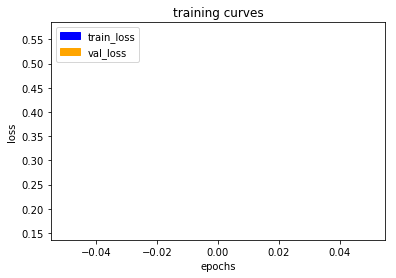

140/140 [==============================] - 83s - loss: 0.5622 - val_loss: 0.1565
Epoch 2/80
139/140 [============================>.] - ETA: 0s - loss: 0.0889

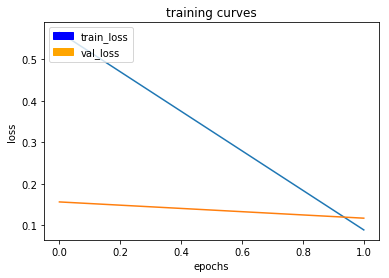

140/140 [==============================] - 79s - loss: 0.0891 - val_loss: 0.1174
Epoch 3/80
139/140 [============================>.] - ETA: 0s - loss: 0.0625

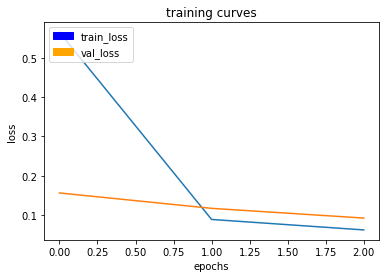

140/140 [==============================] - 79s - loss: 0.0624 - val_loss: 0.0927
Epoch 4/80
139/140 [============================>.] - ETA: 0s - loss: 0.0471

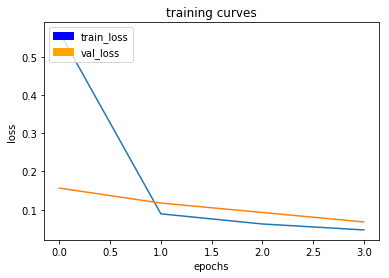

140/140 [==============================] - 79s - loss: 0.0471 - val_loss: 0.0679
Epoch 5/80
139/140 [============================>.] - ETA: 0s - loss: 0.0401

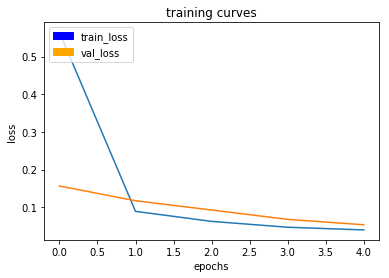

140/140 [==============================] - 79s - loss: 0.0400 - val_loss: 0.0536
Epoch 6/80
139/140 [============================>.] - ETA: 0s - loss: 0.0362

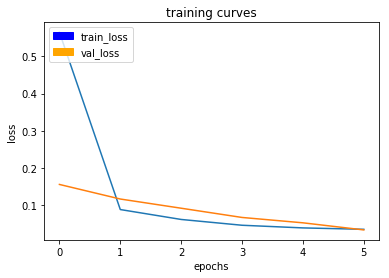

140/140 [==============================] - 79s - loss: 0.0362 - val_loss: 0.0345
Epoch 7/80
139/140 [============================>.] - ETA: 0s - loss: 0.0355

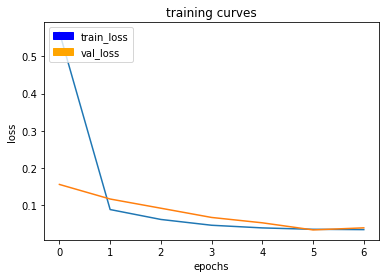

140/140 [==============================] - 79s - loss: 0.0354 - val_loss: 0.0401
Epoch 8/80
139/140 [============================>.] - ETA: 0s - loss: 0.0318

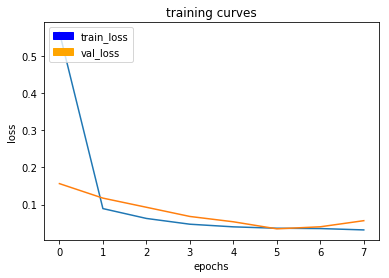

140/140 [==============================] - 80s - loss: 0.0318 - val_loss: 0.0565
Epoch 9/80
139/140 [============================>.] - ETA: 0s - loss: 0.0313

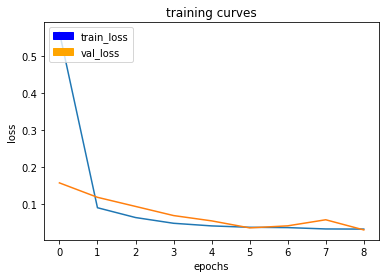

140/140 [==============================] - 79s - loss: 0.0314 - val_loss: 0.0290
Epoch 10/80
139/140 [============================>.] - ETA: 0s - loss: 0.0293

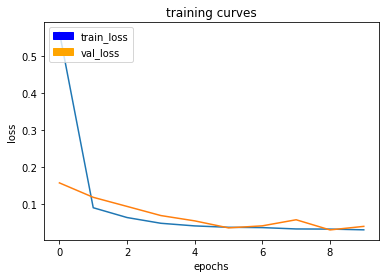

140/140 [==============================] - 79s - loss: 0.0293 - val_loss: 0.0386
Epoch 11/80
139/140 [============================>.] - ETA: 0s - loss: 0.0276

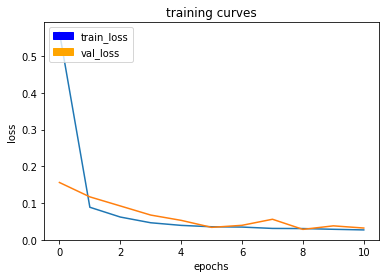

140/140 [==============================] - 79s - loss: 0.0275 - val_loss: 0.0327
Epoch 12/80
139/140 [============================>.] - ETA: 0s - loss: 0.0259

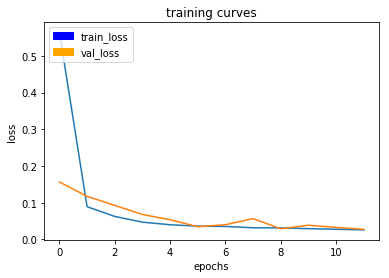

140/140 [==============================] - 79s - loss: 0.0259 - val_loss: 0.0274
Epoch 13/80
139/140 [============================>.] - ETA: 0s - loss: 0.0259

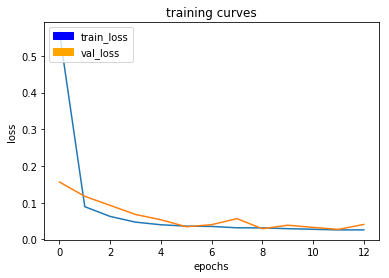

140/140 [==============================] - 79s - loss: 0.0261 - val_loss: 0.0407
Epoch 14/80
139/140 [============================>.] - ETA: 0s - loss: 0.0256

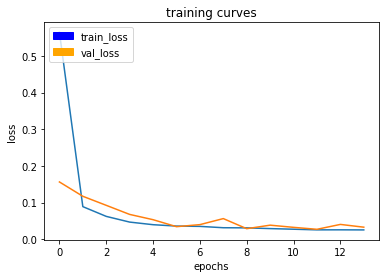

140/140 [==============================] - 79s - loss: 0.0257 - val_loss: 0.0331
Epoch 15/80
139/140 [============================>.] - ETA: 0s - loss: 0.0239

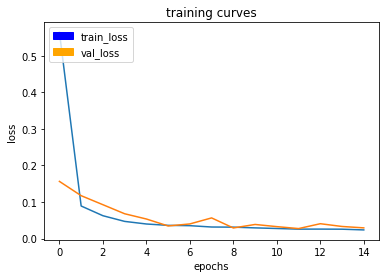

140/140 [==============================] - 79s - loss: 0.0238 - val_loss: 0.0293
Epoch 16/80
139/140 [============================>.] - ETA: 0s - loss: 0.0225

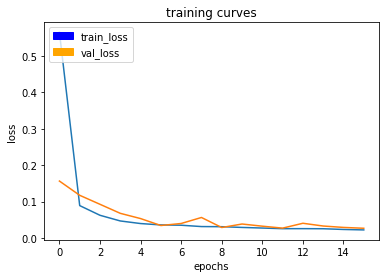

140/140 [==============================] - 79s - loss: 0.0225 - val_loss: 0.0270
Epoch 17/80
139/140 [============================>.] - ETA: 0s - loss: 0.0227

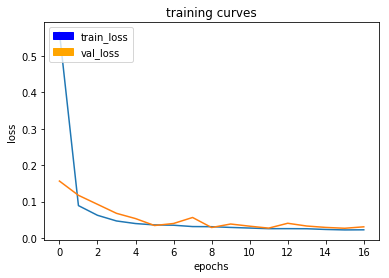

140/140 [==============================] - 79s - loss: 0.0227 - val_loss: 0.0309
Epoch 18/80
139/140 [============================>.] - ETA: 0s - loss: 0.0221

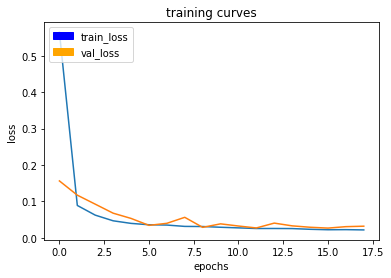

140/140 [==============================] - 79s - loss: 0.0221 - val_loss: 0.0322
Epoch 19/80
139/140 [============================>.] - ETA: 0s - loss: 0.0227

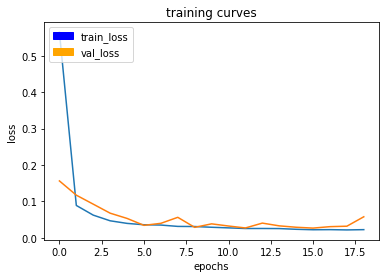

140/140 [==============================] - 79s - loss: 0.0228 - val_loss: 0.0581
Epoch 20/80
139/140 [============================>.] - ETA: 0s - loss: 0.0202

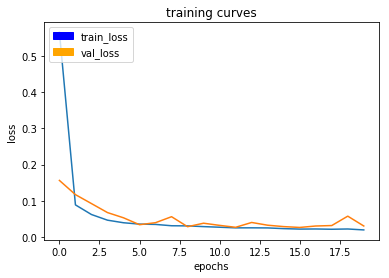

140/140 [==============================] - 79s - loss: 0.0201 - val_loss: 0.0309
Epoch 21/80
139/140 [============================>.] - ETA: 0s - loss: 0.0205

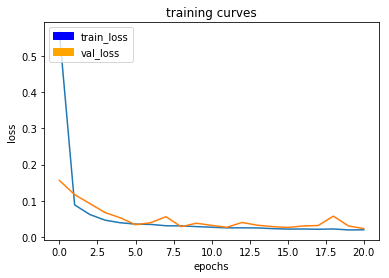

140/140 [==============================] - 79s - loss: 0.0205 - val_loss: 0.0239
Epoch 22/80
139/140 [============================>.] - ETA: 0s - loss: 0.0201

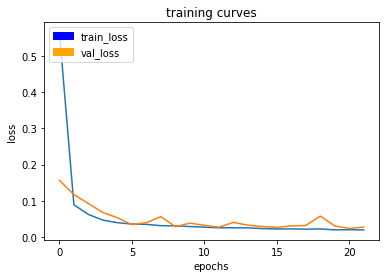

140/140 [==============================] - 79s - loss: 0.0201 - val_loss: 0.0277
Epoch 23/80
139/140 [============================>.] - ETA: 0s - loss: 0.0202

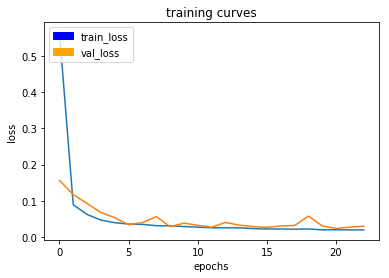

140/140 [==============================] - 79s - loss: 0.0202 - val_loss: 0.0302
Epoch 24/80
139/140 [============================>.] - ETA: 0s - loss: 0.0199

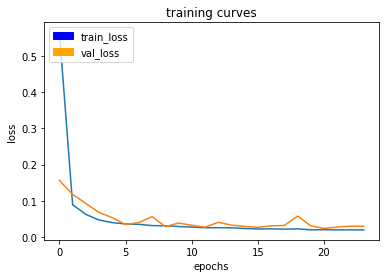

140/140 [==============================] - 79s - loss: 0.0198 - val_loss: 0.0300
Epoch 25/80
139/140 [============================>.] - ETA: 0s - loss: 0.0195

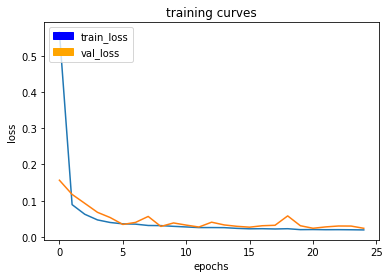

140/140 [==============================] - 79s - loss: 0.0195 - val_loss: 0.0238
Epoch 26/80
139/140 [============================>.] - ETA: 0s - loss: 0.0177

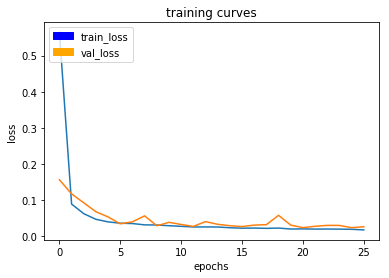

140/140 [==============================] - 79s - loss: 0.0177 - val_loss: 0.0264
Epoch 27/80
139/140 [============================>.] - ETA: 0s - loss: 0.0184

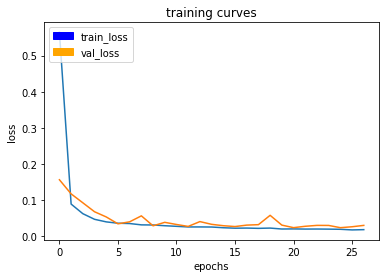

140/140 [==============================] - 79s - loss: 0.0184 - val_loss: 0.0302
Epoch 28/80
139/140 [============================>.] - ETA: 0s - loss: 0.0185

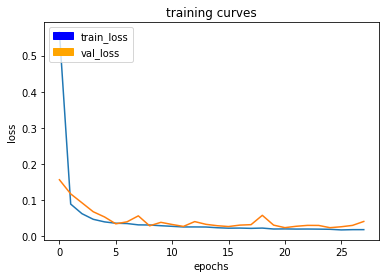

140/140 [==============================] - 79s - loss: 0.0185 - val_loss: 0.0411
Epoch 29/80
139/140 [============================>.] - ETA: 0s - loss: 0.0186

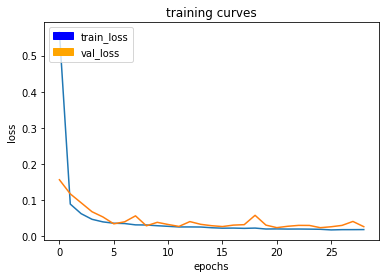

140/140 [==============================] - 79s - loss: 0.0186 - val_loss: 0.0266
Epoch 30/80
139/140 [============================>.] - ETA: 0s - loss: 0.0184

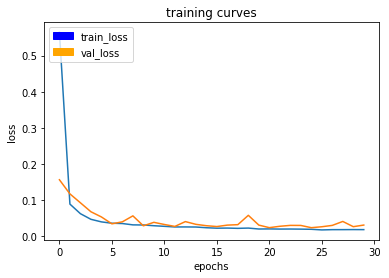

140/140 [==============================] - 79s - loss: 0.0184 - val_loss: 0.0311
Epoch 31/80
139/140 [============================>.] - ETA: 0s - loss: 0.0159

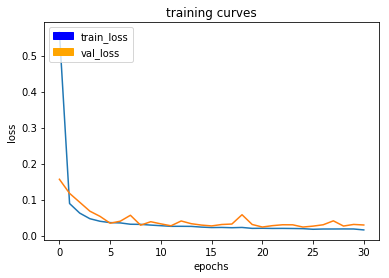

140/140 [==============================] - 79s - loss: 0.0159 - val_loss: 0.0296
Epoch 32/80
139/140 [============================>.] - ETA: 0s - loss: 0.0185

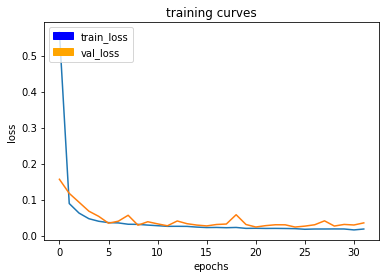

140/140 [==============================] - 79s - loss: 0.0184 - val_loss: 0.0354
Epoch 33/80
139/140 [============================>.] - ETA: 0s - loss: 0.0150

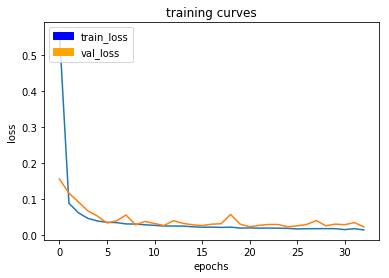

140/140 [==============================] - 79s - loss: 0.0150 - val_loss: 0.0235
Epoch 34/80
139/140 [============================>.] - ETA: 0s - loss: 0.0165

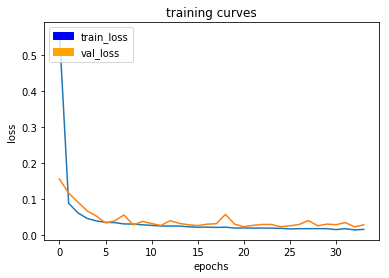

140/140 [==============================] - 79s - loss: 0.0165 - val_loss: 0.0290
Epoch 35/80
139/140 [============================>.] - ETA: 0s - loss: 0.0166

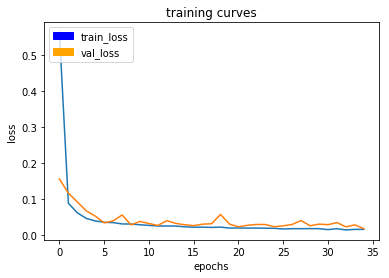

140/140 [==============================] - 79s - loss: 0.0165 - val_loss: 0.0186
Epoch 36/80
139/140 [============================>.] - ETA: 0s - loss: 0.0180

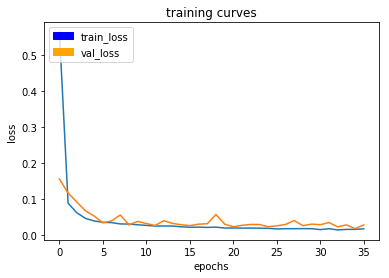

140/140 [==============================] - 79s - loss: 0.0179 - val_loss: 0.0290
Epoch 37/80
139/140 [============================>.] - ETA: 0s - loss: 0.0154

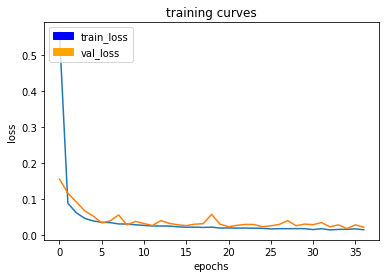

140/140 [==============================] - 79s - loss: 0.0155 - val_loss: 0.0225
Epoch 38/80
139/140 [============================>.] - ETA: 0s - loss: 0.0158

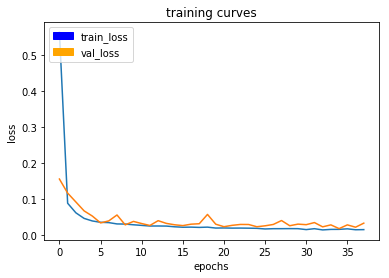

140/140 [==============================] - 79s - loss: 0.0158 - val_loss: 0.0338
Epoch 39/80
139/140 [============================>.] - ETA: 0s - loss: 0.0173

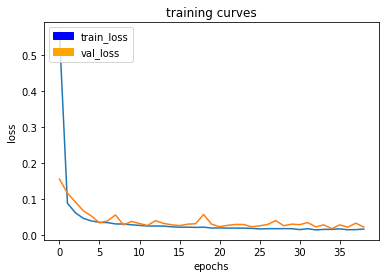

140/140 [==============================] - 79s - loss: 0.0173 - val_loss: 0.0230
Epoch 40/80
139/140 [============================>.] - ETA: 0s - loss: 0.0171

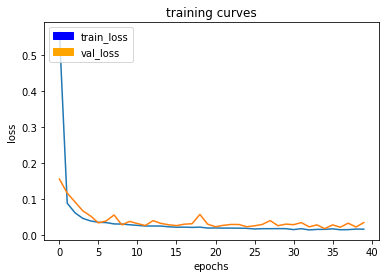

140/140 [==============================] - 79s - loss: 0.0171 - val_loss: 0.0353
Epoch 41/80
139/140 [============================>.] - ETA: 0s - loss: 0.0146

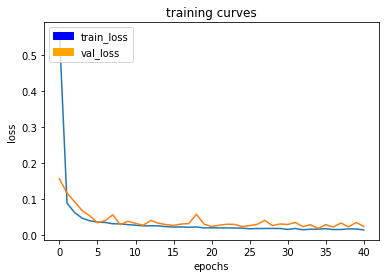

140/140 [==============================] - 79s - loss: 0.0146 - val_loss: 0.0243
Epoch 42/80
139/140 [============================>.] - ETA: 0s - loss: 0.0142

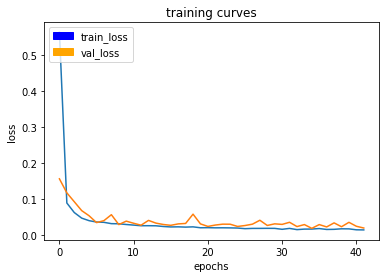

140/140 [==============================] - 79s - loss: 0.0142 - val_loss: 0.0195
Epoch 43/80
139/140 [============================>.] - ETA: 0s - loss: 0.0141

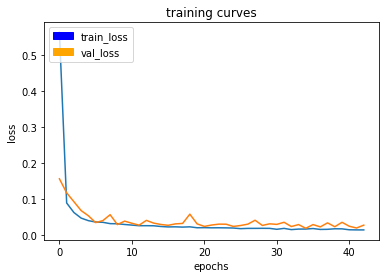

140/140 [==============================] - 79s - loss: 0.0141 - val_loss: 0.0274
Epoch 44/80
139/140 [============================>.] - ETA: 0s - loss: 0.0144

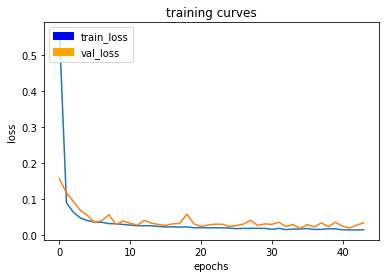

140/140 [==============================] - 79s - loss: 0.0144 - val_loss: 0.0342
Epoch 45/80
139/140 [============================>.] - ETA: 0s - loss: 0.0161

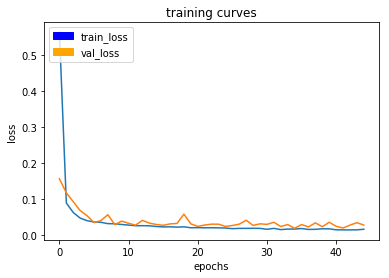

140/140 [==============================] - 79s - loss: 0.0160 - val_loss: 0.0276
Epoch 46/80
139/140 [============================>.] - ETA: 0s - loss: 0.0143

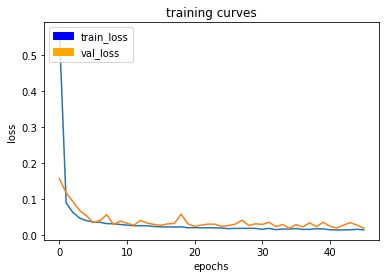

140/140 [==============================] - 79s - loss: 0.0142 - val_loss: 0.0189
Epoch 47/80
139/140 [============================>.] - ETA: 0s - loss: 0.0154

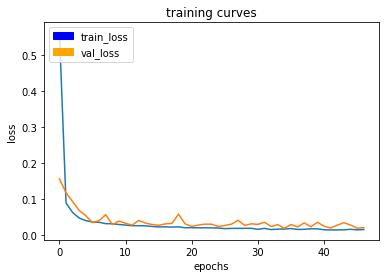

140/140 [==============================] - 79s - loss: 0.0154 - val_loss: 0.0203
Epoch 48/80
139/140 [============================>.] - ETA: 0s - loss: 0.0149

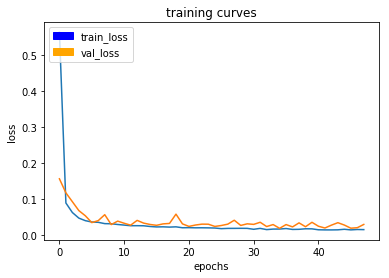

140/140 [==============================] - 79s - loss: 0.0149 - val_loss: 0.0294
Epoch 49/80
139/140 [============================>.] - ETA: 0s - loss: 0.0135

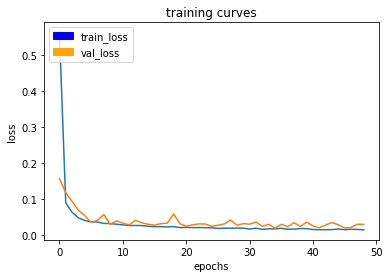

140/140 [==============================] - 79s - loss: 0.0135 - val_loss: 0.0290
Epoch 50/80
139/140 [============================>.] - ETA: 0s - loss: 0.0130

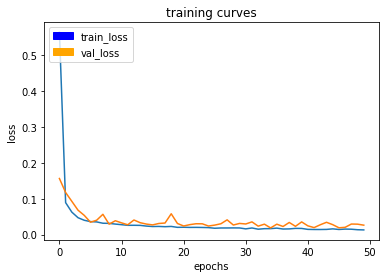

140/140 [==============================] - 79s - loss: 0.0129 - val_loss: 0.0262
Epoch 51/80
139/140 [============================>.] - ETA: 0s - loss: 0.0123

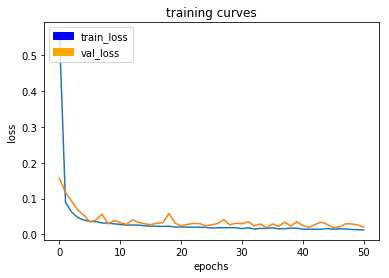

140/140 [==============================] - 79s - loss: 0.0123 - val_loss: 0.0204
Epoch 52/80
139/140 [============================>.] - ETA: 0s - loss: 0.0129

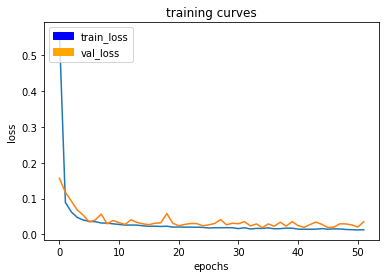

140/140 [==============================] - 79s - loss: 0.0129 - val_loss: 0.0353
Epoch 53/80
139/140 [============================>.] - ETA: 0s - loss: 0.0123

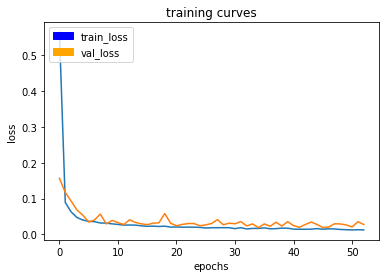

140/140 [==============================] - 79s - loss: 0.0123 - val_loss: 0.0273
Epoch 54/80
139/140 [============================>.] - ETA: 0s - loss: 0.0145

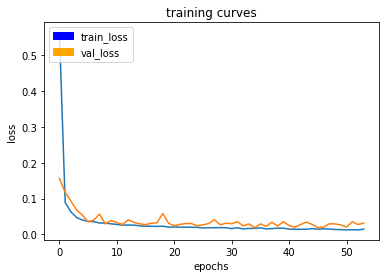

140/140 [==============================] - 80s - loss: 0.0144 - val_loss: 0.0316
Epoch 55/80
139/140 [============================>.] - ETA: 0s - loss: 0.0136

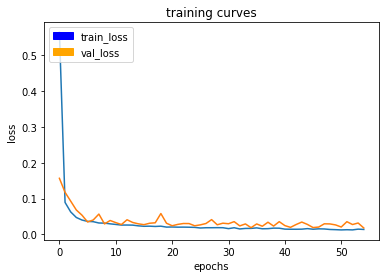

140/140 [==============================] - 79s - loss: 0.0136 - val_loss: 0.0177
Epoch 56/80
139/140 [============================>.] - ETA: 0s - loss: 0.0133

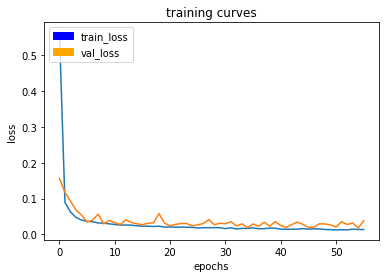

140/140 [==============================] - 80s - loss: 0.0133 - val_loss: 0.0380
Epoch 57/80
139/140 [============================>.] - ETA: 0s - loss: 0.0140

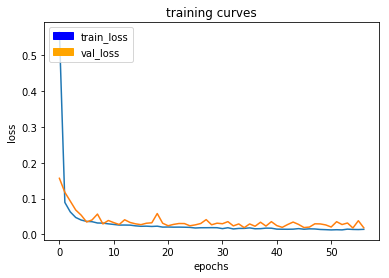

140/140 [==============================] - 79s - loss: 0.0140 - val_loss: 0.0182
Epoch 58/80
139/140 [============================>.] - ETA: 0s - loss: 0.0128

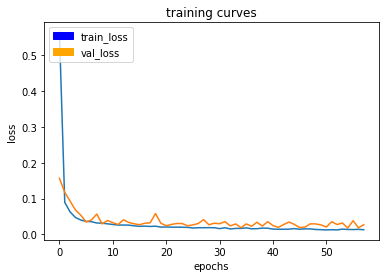

140/140 [==============================] - 79s - loss: 0.0128 - val_loss: 0.0268
Epoch 59/80
139/140 [============================>.] - ETA: 0s - loss: 0.0158

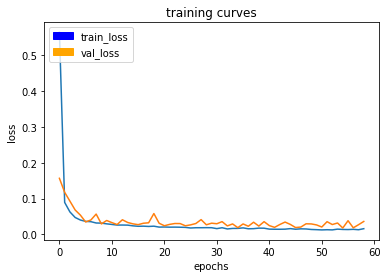

140/140 [==============================] - 79s - loss: 0.0157 - val_loss: 0.0360
Epoch 60/80
139/140 [============================>.] - ETA: 0s - loss: 0.0127

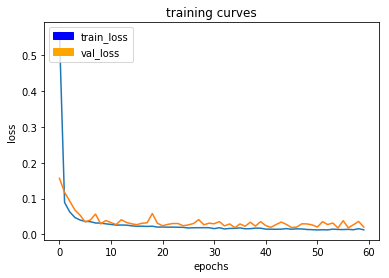

140/140 [==============================] - 80s - loss: 0.0127 - val_loss: 0.0203
Epoch 61/80
139/140 [============================>.] - ETA: 0s - loss: 0.0116

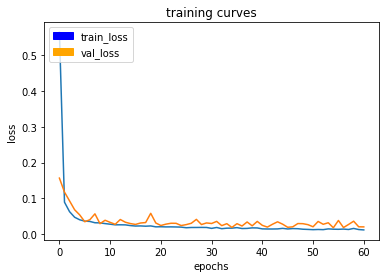

140/140 [==============================] - 79s - loss: 0.0116 - val_loss: 0.0200
Epoch 62/80
139/140 [============================>.] - ETA: 0s - loss: 0.0119

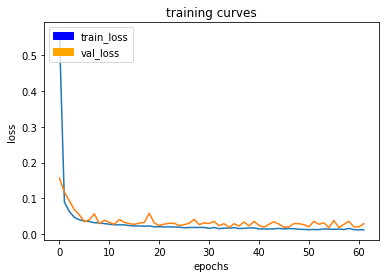

140/140 [==============================] - 79s - loss: 0.0119 - val_loss: 0.0291
Epoch 63/80
139/140 [============================>.] - ETA: 0s - loss: 0.0112

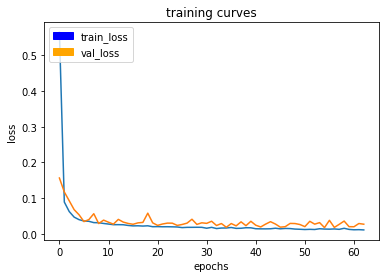

140/140 [==============================] - 79s - loss: 0.0112 - val_loss: 0.0272
Epoch 64/80
139/140 [============================>.] - ETA: 0s - loss: 0.0138

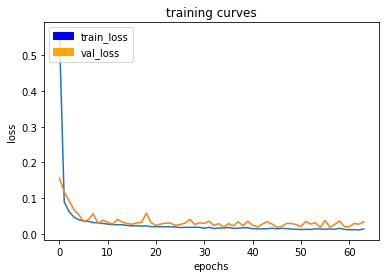

140/140 [==============================] - 79s - loss: 0.0138 - val_loss: 0.0338
Epoch 65/80
139/140 [============================>.] - ETA: 0s - loss: 0.0122

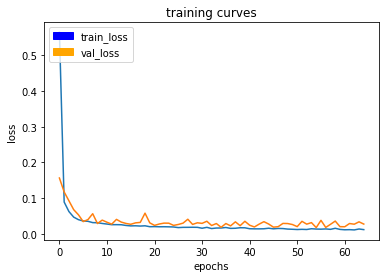

140/140 [==============================] - 79s - loss: 0.0122 - val_loss: 0.0275
Epoch 66/80
139/140 [============================>.] - ETA: 0s - loss: 0.0126

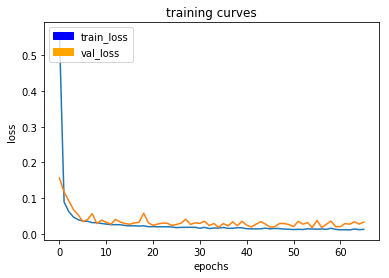

140/140 [==============================] - 79s - loss: 0.0126 - val_loss: 0.0331
Epoch 67/80
139/140 [============================>.] - ETA: 0s - loss: 0.0132

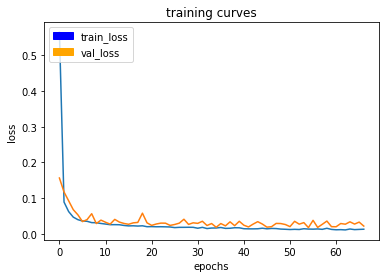

140/140 [==============================] - 79s - loss: 0.0132 - val_loss: 0.0219
Epoch 68/80
139/140 [============================>.] - ETA: 0s - loss: 0.0124

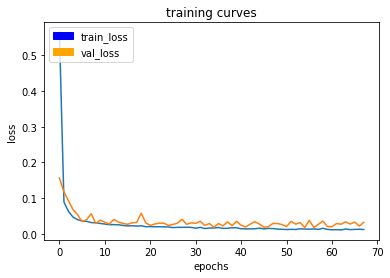

140/140 [==============================] - 79s - loss: 0.0123 - val_loss: 0.0327
Epoch 69/80
139/140 [============================>.] - ETA: 0s - loss: 0.0118

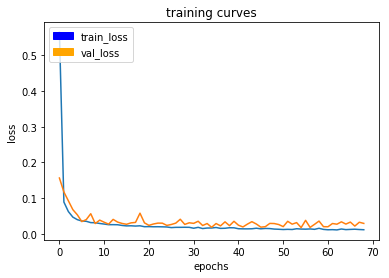

140/140 [==============================] - 79s - loss: 0.0118 - val_loss: 0.0294
Epoch 70/80
139/140 [============================>.] - ETA: 0s - loss: 0.0114

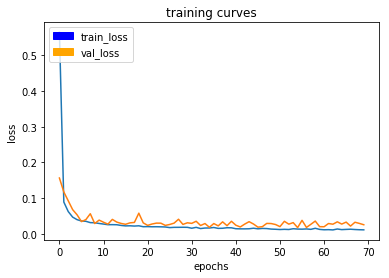

140/140 [==============================] - 79s - loss: 0.0114 - val_loss: 0.0257
Epoch 71/80
139/140 [============================>.] - ETA: 0s - loss: 0.0113

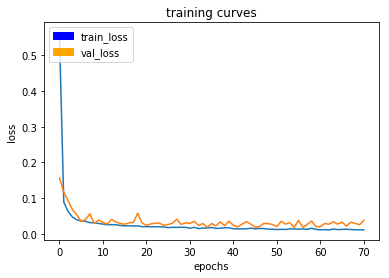

140/140 [==============================] - 79s - loss: 0.0113 - val_loss: 0.0378
Epoch 72/80
139/140 [============================>.] - ETA: 0s - loss: 0.0109

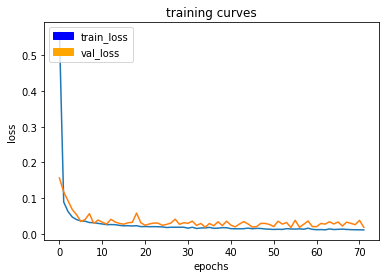

140/140 [==============================] - 79s - loss: 0.0109 - val_loss: 0.0184
Epoch 73/80
139/140 [============================>.] - ETA: 0s - loss: 0.0124

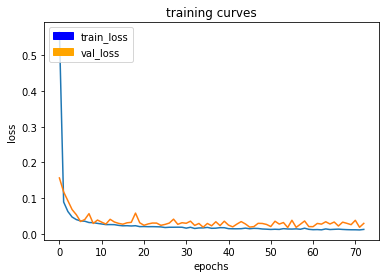

140/140 [==============================] - 79s - loss: 0.0124 - val_loss: 0.0292
Epoch 74/80
139/140 [============================>.] - ETA: 0s - loss: 0.0137

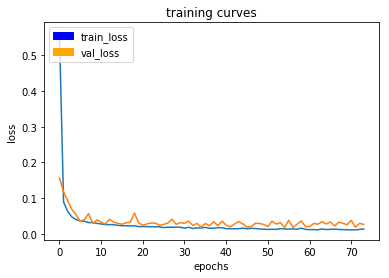

140/140 [==============================] - 79s - loss: 0.0137 - val_loss: 0.0266
Epoch 75/80
139/140 [============================>.] - ETA: 0s - loss: 0.0118

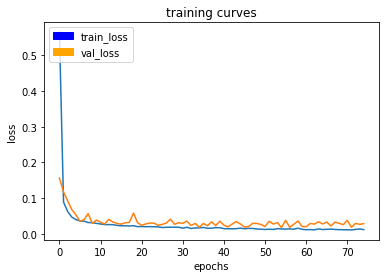

140/140 [==============================] - 79s - loss: 0.0118 - val_loss: 0.0283
Epoch 76/80
139/140 [============================>.] - ETA: 0s - loss: 0.0120

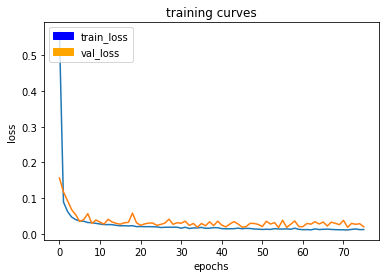

140/140 [==============================] - 79s - loss: 0.0120 - val_loss: 0.0197
Epoch 77/80
139/140 [============================>.] - ETA: 0s - loss: 0.0156

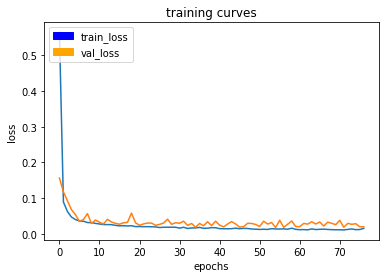

140/140 [==============================] - 79s - loss: 0.0156 - val_loss: 0.0197
Epoch 78/80
139/140 [============================>.] - ETA: 0s - loss: 0.0121

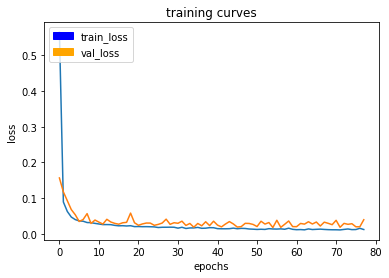

140/140 [==============================] - 79s - loss: 0.0121 - val_loss: 0.0395
Epoch 79/80
139/140 [============================>.] - ETA: 0s - loss: 0.0109

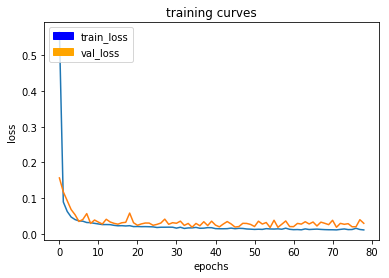

140/140 [==============================] - 79s - loss: 0.0109 - val_loss: 0.0294
Epoch 80/80
139/140 [============================>.] - ETA: 0s - loss: 0.0106

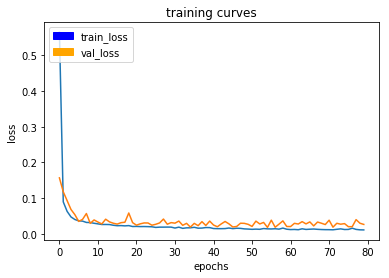

140/140 [==============================] - 79s - loss: 0.0106 - val_loss: 0.0260


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [11]:
# Save your trained model weightsc
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [12]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'

# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

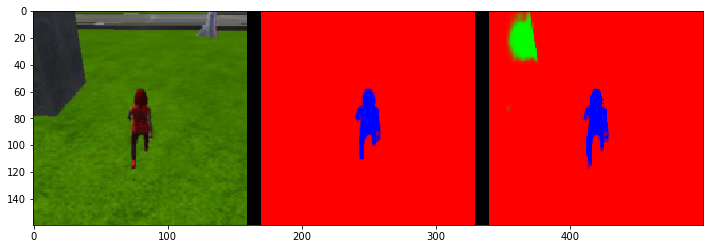

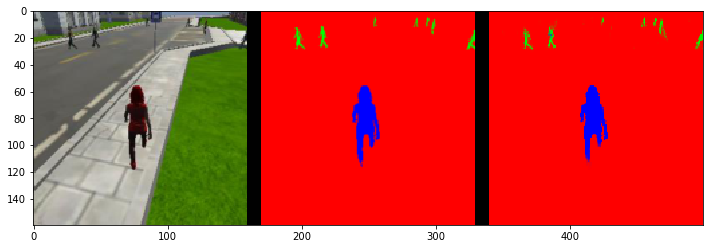

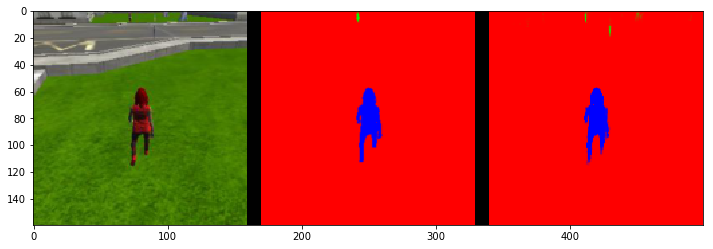

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

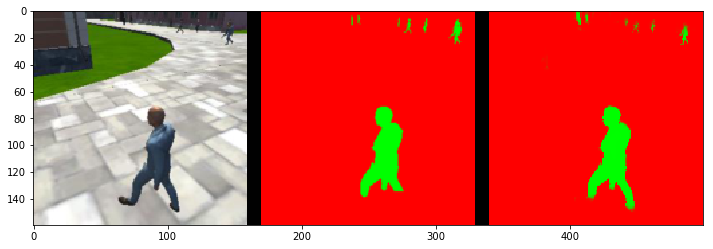

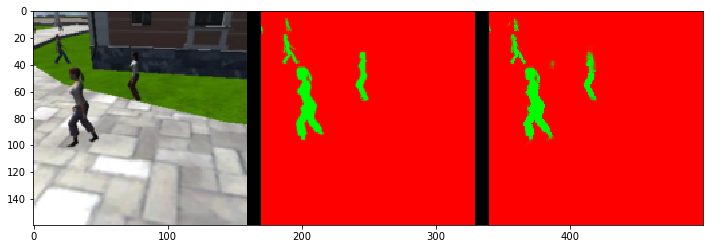

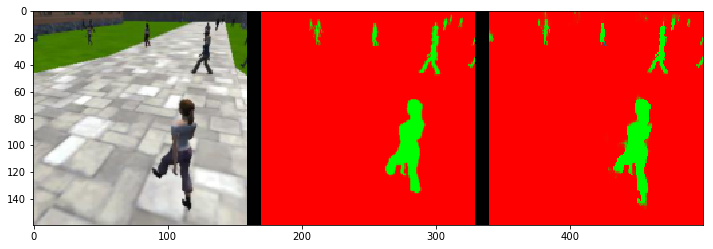

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

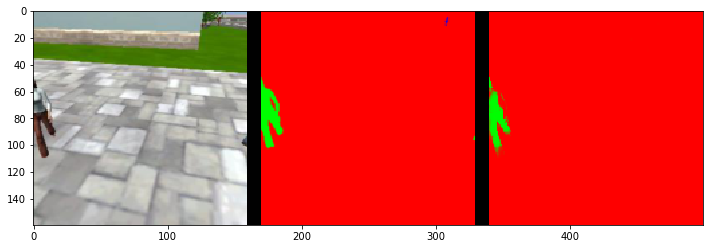

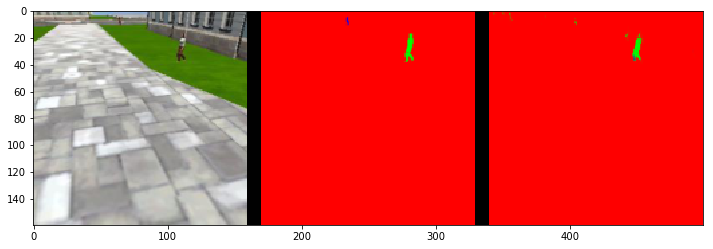

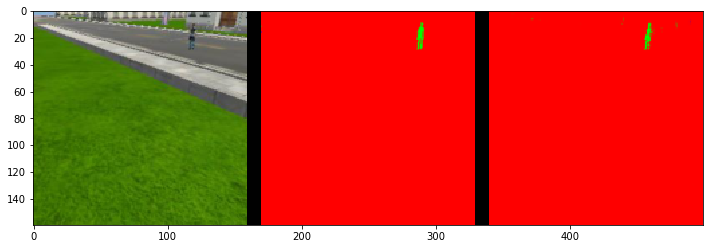

In [16]:
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9955358304383236
average intersection over union for other people is 0.38126742144404113
average intersection over union for the hero is 0.9155461871121797
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9888140009987707
average intersection over union for other people is 0.7769066764158795
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 41, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965830020149288
average intersection over union for other people is 0.46844769532120223
average intersection over union for the hero is 0.25828685750098845
number true positives: 139, number false positives: 2, number false negatives: 162


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7678369195922989


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.586916522307


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.450656174546
